# Kinematics of Qronk

Qronk will have 12 degrees of freedom - 3 servo motors in each leg.

To move the robot we will need to use inverse kinematics, which will allow us to determine the angle of the servo motors based on our desired locations. This will have to be done for two components to allow freedom in control. 

1. Chassis: find the displacement and rotation of the chassis first, to adjust centre of gravity.
2. Feet: find the displacement of the feet, to move the robot forward.  

For development, we will begin by focusing on creating the inverse kinematics of one leg to move a foot. Chassis will need to be figured out afterwards. 


### To-do

- Fix bug in inverseKinematics where x-coordinate of the foot is always 0 
- Add raise errors for situations where forward/inverse kinematics are off limits
- Combine foot trajectory into a walking gait motion (for all four legs)
- Connect the resulting trajectory to qronk_pybullet as a function 

In [8]:
# Import libraries
import os

from numpy import pi, cos, sin, sqrt, arctan2, arccos, sign

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits import mplot3d


# Load URDF model
URDF_DIR = os.getcwd() + "/../qronk_description/urdf/"
xacro_model = URDF_DIR + "qronk.urdf.xacro"
urdf_model = !xacro {xacro_model}

## Forward-Kinematics

The forward kinematics is calculated based on the following diagram. Single leg kinematics will be done using the front-left leg of Qronk. Measurements are approximate, so re-measuring needs to be done on CAD. 

<img src="media/joint_diagram.png" alt="joint_diagram" width="500"/>

In [9]:
B = 0  # body to hip
L1 = 3.5  # hip to upper-leg
L2 = 10  # upper-leg to lower-leg
L3 = 10  # lower-leg to foot


def forwardKinematicsLeft(th1, th2, th3):
    # Body to hip
    T01_translation = np.array([[1, 0, 0, B], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    T01_rotation = np.array(
        [
            [1, 0, 0, 0],
            [0, cos(th1), -sin(th1), 0],
            [0, sin(th1), cos(th1), 0],
            [0, 0, 0, 1],
        ]
    )
    T01 = T01_translation @ T01_rotation

    # Hip to upper-leg
    T12_translation = np.array(
        [[1, 0, 0, 0], [0, 1, 0, L1], [0, 0, 1, 0], [0, 0, 0, 1]]
    )
    T12_rotation = np.array(
        [
            [cos(th2), 0, sin(th2), 0],
            [0, 1, 0, 0],
            [-sin(th2), 0, cos(th2), 0],
            [0, 0, 0, 1],
        ]
    )
    T12 = T12_translation @ T12_rotation

    # Upper-leg to lower-leg
    T23_translation = np.array(
        [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, -L2], [0, 0, 0, 1]]
    )
    T23_rotation = np.array(
        [
            [cos(th3), 0, sin(th3), 0],
            [0, 1, 0, 0],
            [-sin(th3), 0, cos(th3), 0],
            [0, 0, 0, 1],
        ]
    )
    T23 = T23_translation @ T23_rotation

    # Lower-leg to foot
    T3e = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, -L3], [0, 0, 0, 1]])

    # Combine matrices to get end-effector pose
    T01 = T01
    T02 = T01 @ T12
    T03 = T01 @ T12 @ T23
    T0e = T01 @ T12 @ T23 @ T3e

    # Get joint positions
    J1 = T01[0:3, 3]
    J2 = T02[0:3, 3]
    J3 = T03[0:3, 3]
    Je = T0e[0:3, 3]

    JointPos = [J1, J2, J3, Je]
    return JointPos


def forwardKinematicsRight(th1, th2, th3):
    # Body to hip
    T01_translation = np.array([[1, 0, 0, B], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    T01_rotation = np.array(
        [
            [1, 0, 0, 0],
            [0, cos(th1), -sin(th1), 0],
            [0, sin(th1), cos(th1), 0],
            [0, 0, 0, 1],
        ]
    )
    T01 = T01_translation @ T01_rotation

    # Hip to upper-leg
    T12_translation = np.array(
        [[1, 0, 0, 0], [0, 1, 0, -L1], [0, 0, 1, 0], [0, 0, 0, 1]]  # this is the only difference from Left
    )
    T12_rotation = np.array(
        [
            [cos(th2), 0, sin(th2), 0],
            [0, 1, 0, 0],
            [-sin(th2), 0, cos(th2), 0],
            [0, 0, 0, 1],
        ]
    )
    T12 = T12_translation @ T12_rotation

    # Upper-leg to lower-leg
    T23_translation = np.array(
        [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, -L2], [0, 0, 0, 1]]
    )
    T23_rotation = np.array(
        [
            [cos(th3), 0, sin(th3), 0],
            [0, 1, 0, 0],
            [-sin(th3), 0, cos(th3), 0],
            [0, 0, 0, 1],
        ]
    )
    T23 = T23_translation @ T23_rotation

    # Lower-leg to foot
    T3e = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, -L3], [0, 0, 0, 1]])

    # Combine matrices to get end-effector pose
    T01 = T01
    T02 = T01 @ T12
    T03 = T01 @ T12 @ T23
    T0e = T01 @ T12 @ T23 @ T3e

    # Get joint positions
    J1 = T01[0:3, 3]
    J2 = T02[0:3, 3]
    J3 = T03[0:3, 3]
    Je = T0e[0:3, 3]

    JointPos = [J1, J2, J3, Je]
    return JointPos

## Plotting the model

To visualise the calculations, the model will need to be plotted. This can either be done in a 3d plot, or a pair of 2d plots (front and side views). Pair of 2d plots seem to be more functional, but testing both of them out may be beneficial. 

Making a function to create the plot for given angles of joints will be required. Making a slider to adjust joint angles may be helpful for testing purposes but likely unnecessary. 


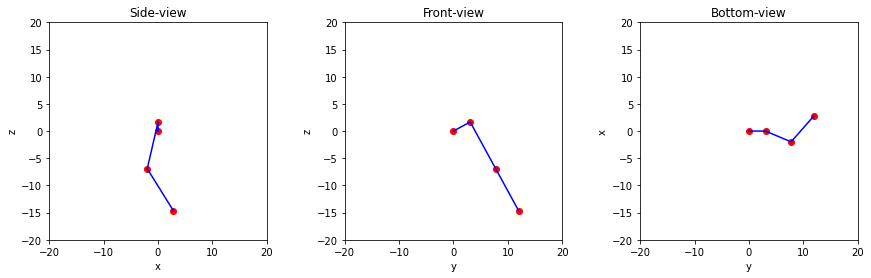

In [10]:
def plotLeg(JointPos):
    """Plots the leg in 3D space, given the joint positions in coordinates."""

    # unpack the joint positions
    x, y, z = zip(*JointPos)

    # create a figure
    plt.figure(figsize=(15, 4))

    # plot x-z plane (side-view)
    plt.subplot(131)
    plt.plot(x, z, "b-")
    plt.scatter(x, z, color="red")
    plt.title("Side-view")
    plt.xlabel("x")
    plt.ylabel("z")
    plt.axis("square")
    plt.axis([-20, 20, -20, 20])

    # plot y-z plane (front-view)
    plt.subplot(132)
    plt.plot(y, z, "b-")
    plt.scatter(y, z, color="red")
    plt.title("Front-view")
    plt.xlabel("y")
    plt.ylabel("z")
    plt.axis("square")
    plt.axis([-20, 20, -20, 20])

    # plot x-y plane (bottom-view)
    plt.subplot(133)
    plt.plot(y, x, "b-")
    plt.scatter(y, x, color="red")
    plt.title("Bottom-view")
    plt.xlabel("y")
    plt.ylabel("x")
    plt.axis("square")
    plt.axis([-20, 20, -20, 20])

    """
    Removed 3D view as it is hard to read

    # plot 3D view
    plt.subplot(144, projection="3d")
    plt.plot(x, y, z, "b-")
    plt.title("3D view")

    plt.show()
    """


# Plot an example leg with arbitrary joint positions (for testing)
th1 = 0.5  # hip servo
th2 = 0.2  # upper-leg servo
th3 = -0.7  # lower-leg servo
plotLeg(forwardKinematicsLeft(th1, th2, th3))

## Calculating the inverse kinematics 

To calculate the inverse kinematics of the leg, basic trigonometry will be used. It will be easier to first perform this by hand and then implement it into this notebook. 

There also seems to be matrix methods available - if anyone finds more on this and find it applicable, we can discuss on using that instead to make the process faster. 

Some points to note before starting: 
- The angle of the joint connecting the hip and upper-leg will need to be determined first, as it provides the only out-of-plane movement.
- There will be two solutions (or more?) for each location, due to the fact that two of the links share the links share the same plane. 

<img src="media/invkin1.jpg" alt="invkin_1" width="500"/>
<img src="media/invkin2.jpg" alt="invkin_2" width="500"/>
<img src="media/invkin3.jpg" alt="invkin_3" width="500"/>
<img src="media/invkin4.jpg" alt="invkin_4" width="500"/>

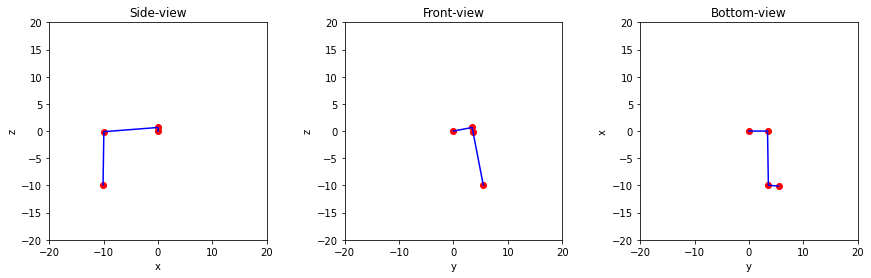

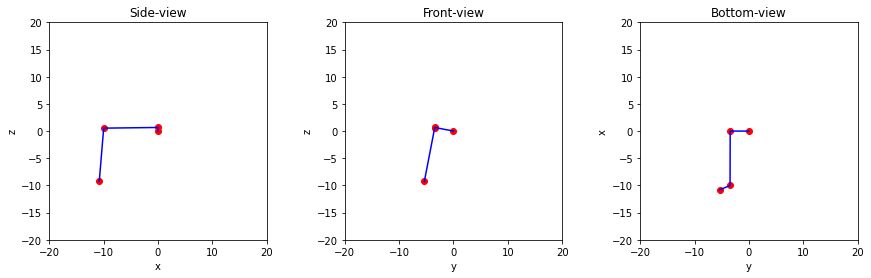

In [23]:
def inverseKinematicsLeft(Je):
    # Extract the x, y, z coordinates of the end effector position
    x, y, z = Je

    # Find th1 by considering the front view of the leg
    d1yz = sqrt(y**2 + z**2)
    a1 = abs(arccos(L1 / d1yz))
    a2 = arctan2(z, y)
    th1 = a1 + a2

    # Find the required lengths from the 3D view
    d1xyz = sqrt(x**2 + y**2 + z**2)
    d2 = sqrt(d1xyz**2 - L1**2)
    x_A, y_A, z_A = 0, L1*cos(th1), L1*sin(th1)
    
    # Find the required angle by considering the side view of the leg
    a3 = arctan2((x_A - x), (z_A - z))

    # Find th2 th3 by considering the plane of lower/upper leg
    a4 = (d2**2 + L2**2 - L3**2)/(2*d2*L2)
    th2 = a3 + a4
    th3 = -2*a4

    return th1, th2, th3

def inverseKinematicsRight(Je):
    # Extract the x, y, z coordinates of the end effector position
    x, y, z = Je
    y = -y

    # Find th1 by considering the front view of the leg
    d1yz = sqrt(y**2 + z**2)
    a1 = abs(arccos(L1 / d1yz))
    a2 = arctan2(z, y)
    th1 = -(a1 + a2)

    # Find the required lengths from the 3D view
    d1xyz = sqrt(x**2 + y**2 + z**2)
    d2 = sqrt(d1xyz**2 - L1**2)
    x_A, y_A, z_A = 0, L1*cos(th1), L1*sin(th1)
    
    # Find the required angle by considering the side view of the leg
    a3 = arctan2((x_A - x), (z_A - z))

    # Find th2 th3 by considering the plane of lower/upper leg
    a4 = (d2**2 + L2**2 - L3**2)/(2*d2*L2)
    th2 = a3 + a4
    th3 = -2*a4

    return th1, th2, th3


# Confirm that all left and right kinematics work correctly
th1, th2, th3 = inverseKinematicsLeft((-10, 5.5, -10))
plotLeg(forwardKinematicsLeft(th1, th2, th3))


th1, th2, th3 = inverseKinematicsRight((-10, -5.5, -10))
plotLeg(forwardKinematicsRight(th1, th2, th3))

## Making a gait sequence of semi-circle path

(-0.25, 5.25, -15.124753341053534, -9.624753341053534)

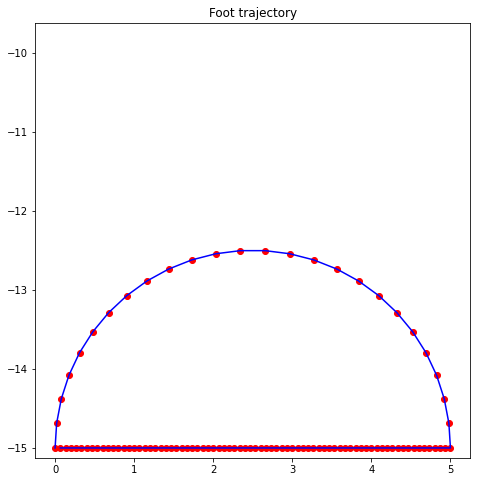

In [12]:
# Define gait parameters
radius = 2.5  # radius of the circle
period = 100  # number of frames per step
swing_phase_ratio = 0.25  # percentage of period that foot is off the ground
origin = (0, 3.5, -15) # origin of the circle

def trajectory_semicircle(period, swing_phase_ratio, origin, radius=2.5):
    """Generates a semicircle trajectory for the foot.

    Args:
        period (int): Number of frames per step.
        swing_phase_ratio (float): Percentage of period that foot is off the ground.
        origin (tuple): Origin of the circle.
        radius (int, optional): Radius of the circle. Defaults to 5.

    Returns:
        list: List of coordinates for the trajectory.
    """

    swing_time = period * swing_phase_ratio
    ground_time = period * (1 - swing_phase_ratio)
    foot_coords = []
    joint_angles = []

    for t in range(period):
        if t < swing_time:
            x = origin[0] + radius - radius * cos(pi * t / swing_time)
            y = origin[1]
            z = origin[2] + radius * sin(pi * t / swing_time)
        else:
            x = origin[0] + radius + radius - 2 * radius * (t - swing_time) / ground_time
            y = origin[1]
            z = origin[2]
        foot_coords.append((x, y, z))
        joint_angles.append(inverseKinematicsLeft((x, y, z)))

    return foot_coords, joint_angles

# Plot the trajectory of the foot for testing 
foot_coords, joint_angles = trajectory_semicircle(period, swing_phase_ratio, origin)
x, y, z = zip(*foot_coords)
plt.figure(figsize=(8, 8))
plt.plot(x, z, "b-")
plt.scatter(x, z, color="red")
plt.title("Foot trajectory")
plt.axis("square")

## Making animation for gait sequence

First, we will start with making the foot follow a semicircle path. Make a plot animation to show that the inverse kinematics works for this. 

Other projects seem to use a separate file system called .gait or something similar - should we consider doing something like this? We can first test using an array for just one leg, then decide whether such system will be necessary for gait sequences. 

In [13]:
JointPosArray = [forwardKinematicsLeft(*angles) for angles in joint_angles]

## Determining the workspace

Calculating the workspace of the leg may be helpful for future calculations. This is the plot of all possible locations the foot can reach. To do so, joint angle limits will need to be determined (consider internal collisions and servo limits).  